## Drive Mounter

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Set up tensorBoard

In [0]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
%tensorboard --logdir logs

In [0]:
from tensorboard import notebook
notebook.list() 

Known TensorBoard instances:
  - port 6006: logdir logs (started 0:00:01 ago; pid 331)


In [0]:
notebook.display(port=6006, height=1000)

## Modelling 

In [0]:
import tensorflow as tf
import numpy as np

import keras
from keras.models import Model, load_model
from keras.layers import Input ,BatchNormalization , Activation 
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate


def Convolution(input_tensor,filters):
    
    x = Conv2D(filters=filters,kernel_size=(3, 3),padding = 'same',strides=(1, 1))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 
    return x

def model(input_shape):
    
    inputs = Input((input_shape))
    
    conv_1 = Convolution(inputs,32)
    
    maxp_1 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_1)
    
    conv_2 = Convolution(maxp_1,64)
    maxp_2 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_2)
    
    conv_3 = Convolution(maxp_2,128)
    
    maxp_3 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_3)
    
    conv_4 = Convolution(maxp_3,256)
    maxp_4 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_4)
    
    conv_5 = Convolution(maxp_4,512)
   
    upsample_6 = UpSampling2D((2, 2)) (conv_5)

    upsample_6 = concatenate([upsample_6, conv_4])
    
    conv_6 = Convolution(upsample_6,256)
    upsample_7 = UpSampling2D((2, 2)) (conv_6)
    
    upsample_7 = concatenate([upsample_7, conv_3])
    
    conv_7 = Convolution(upsample_7,128)
    upsample_8 = UpSampling2D((2, 2)) (conv_7)
    
    upsample_8 = concatenate([upsample_8, conv_2])

    conv_8 = Convolution(upsample_8,64)
    upsample_9 = UpSampling2D((2, 2)) (conv_8)
    
    upsample_9 = concatenate([upsample_9, conv_1])
    
    conv_9 = Convolution(upsample_9,32)
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv_9)
    
    model = Model(inputs=[inputs], outputs=[outputs]) 
    
    return model

Using TensorFlow backend.


## Dataset loading

In [0]:
path='drive/My Drive/MS_data_k_fold/'

In [0]:
import os
ext="Prepared_data"
fldr=path+ext

In [0]:
import os
import numpy as np
import pandas as pd

def return_sets(i,fldr):
  sub_fldr=fldr+'/'+str(i)
  k=os.listdir(sub_fldr)
  for fl in k:
    if 'test' in fl:
      test_X=sub_fldr+'/'+fl+'/X.npy'
      X_test=np.load(test_X)
      test_Y=sub_fldr+'/'+fl+'/Y.npy'
      Y_test=np.load(test_Y)
    if 'train' in fl:
      train_X=sub_fldr+'/'+fl+'/X.npy'
      X_train=np.load(train_X)
      train_Y=sub_fldr+'/'+fl+'/Y.npy'
      Y_train=np.load(train_Y)
    if 'validate' in fl:
      validate_X=sub_fldr+'/'+fl+'/X.npy'
      X_validate=np.load(validate_X)
      validate_Y=sub_fldr+'/'+fl+'/Y.npy'
      Y_validate=np.load(validate_Y)
  return X_test,Y_test,X_train,Y_train,X_validate,Y_validate

## Performance Metrices

In [0]:
from keras import backend as K
import numpy as np
import tensorflow as tf

# Computing Dice_Coefficient
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

## Accuracy Plots

In [0]:
import numpy as np
import matplotlib.pyplot as plt

# Accuracy vs Epoch
def Accuracy_Graph(history,i,fldr):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    #plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    file_1=fldr+'/'+str(i)+'/Accuracy.png'
    plt.savefig(file_1)
    plt.show()
    
# Dice Similarity Coefficient vs Epoch
def Dice_coefficient_Graph(history,i,fldr):

    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    #plt.title('Dice_Coefficient')
    plt.ylabel('Dice_Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    file_1=fldr+'/'+str(i)+'/Dice_coef.png'
    plt.savefig(file_1)
    plt.show()
# Loss vs Epoch
def Loss_Graph(history,i,fldr):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    file_1=fldr+'/'+str(i)+'/Loss.png'
    plt.savefig(file_1)
    plt.show()

## Model executer

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import json
#import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input ,BatchNormalization , Activation 
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import datetime



def executer(type_1,model,X_test,Y_test,X_train,Y_train,X_validate,Y_validate,fldr,i):
  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
  #model = model(input_shape = (256,256,5))
  model.summary()
  file_1=fldr+'/'+str(i)+'/'+'Modified_UNet_'+type_1+'.h5'
  checkpointer = ModelCheckpoint(file_1, verbose=1)
  callback_list=[checkpointer,tensorboard_callback]
  record_file=fldr+'/'+str(i)+'/record.json'
  if os.path.exists(record_file):
    f=open(record_file,'r')
    data=json.load(f)
  else:
    data={}
  # Compiling the model
  k_adam=Adam(lr=0.001)
  model.compile(optimizer=k_adam, loss='binary_crossentropy', metrics=['accuracy',dice_coef,precision,sensitivity,specificity])
  # Fitting the model over the data
  history = model.fit(X_train,Y_train,validation_data=(X_validate,Y_validate),batch_size=32,epochs=60,validation_split=0.20,verbose=1,initial_epoch=0,callbacks=callback_list)

  # Saving the model
  model.save(file_1)
  history.history

  # Evaluating the model on the training and testing data 
  train_eval=model.evaluate(x=X_train, y=Y_train, batch_size=32 , verbose=1, sample_weight=None, steps=None)
  test_eval=model.evaluate(x=X_test, y=Y_test, batch_size=32, verbose=1, sample_weight=None, steps=None)
  data[str(i)]={}
  data[str(i)]["training"]=train_eval
  data[str(i)]["testing"]=test_eval

  with open(record_file, "w") as outfile:
			json.dump(data, outfile)
  # Plotting the Graphs of Accuracy, Dice_coefficient, Loss at each epoch on Training and Testing data
 

  return history


## Caller

In [0]:
def caller():
  path='drive/My Drive/MS_data_k_fold/'
  list_c=['Major']
  ext='Prepared_data'
  mdl=model(input_shape = (256,256,5))
  for i in list_c:
    j=3
    while j<=3:
      fldr=path+i+'/'+ext
      X_test,Y_test,X_train,Y_train,X_validate,Y_validate=return_sets(j,fldr)
      history=executer(i,mdl,X_test,Y_test,X_train,Y_train,X_validate,Y_validate,fldr,j)
      Accuracy_Graph(history,j,fldr)
      Dice_coefficient_Graph(history,j,fldr)
      Loss_Graph(history,j,fldr)
      j+=1

## main

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 5) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 1472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

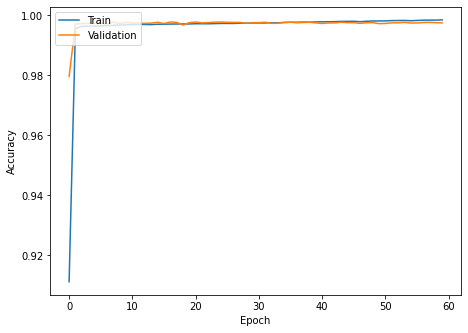

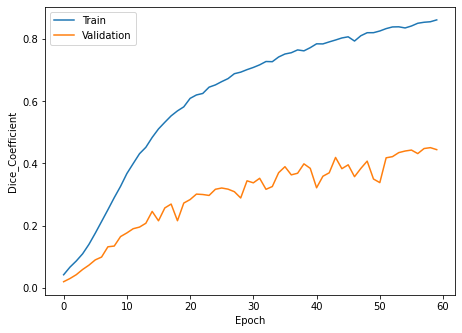

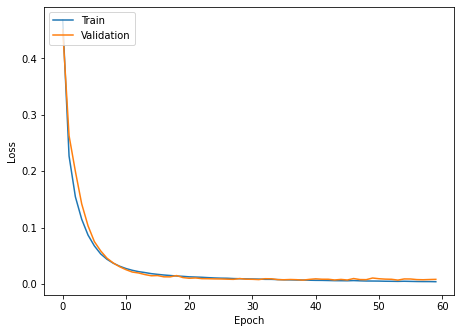

In [0]:
caller()